In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings

import pandas as pd
import numpy as np
import yfinance as yf

from pypfopt.expected_returns import ema_historical_return, capm_return
from pypfopt.risk_models import exp_cov, fix_nonpositive_semidefinite, CovarianceShrinkage

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from utils import Nasdaq100

## Global Settings

In [21]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

test_end_date = '2019-12-31'
test_start_date = (pd.to_datetime(test_end_date) - pd.DateOffset(months=16)).strftime('%Y-%m-%d')
train_end_date = (pd.to_datetime(test_start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
train_start_date = (pd.to_datetime(train_end_date) - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

train_start_date, train_end_date, test_start_date, test_end_date

('2013-08-30', '2018-08-30', '2018-08-31', '2019-12-31')

## Data

Our investment horizon is 16 months. We will choose the periodicity to be daily prices, using five years of historical daily closing prices as a starting point for portfolio optimization. For out of sample, we will use the last 16 months of data (counting from today) to evaluate the performance of the portfolio. This time frame is long enough to capture a variety of market conditions and reduce the impact of short-term fluctuations, but not so long that it becomes difficult to identify meaningful patterns or trends in the data.

In [22]:
# Nasdaq 100
nasdaq100_mapping = {
    'AAPL': 'Apple Inc.',
    'ABBV': 'AbbVie Inc.',
    'ABMD': 'Abiomed Inc.',
    'ACN': 'Accenture plc',
    'ADBE': 'Adobe Inc.',
    'ADI': 'Analog Devices Inc.',
    'ADP': 'Automatic Data Processing Inc.',
    'ADSK': 'Autodesk Inc.',
    'AEP': 'American Electric Power Company Inc.',
    'ALGN': 'Align Technology Inc.',
    'AMAT': 'Applied Materials Inc.',
    'AMD': 'Advanced Micro Devices Inc.',
    'AMGN': 'Amgen Inc.',
    'AMZN': 'Amazon.com Inc.',
    'ANSS': 'ANSYS Inc.',
    'ANTM': 'Anthem Inc.',
    'ASML': 'ASML Holding NV',
    'ATVI': 'Activision Blizzard Inc.',
    'AVGO': 'Broadcom Inc.',
    'BIDU': 'Baidu Inc.',
    'BIIB': 'Biogen Inc.',
    'BKNG': 'Booking Holdings Inc.',
    'BMRN': 'BioMarin Pharmaceutical Inc.',
    'BMY': 'Bristol-Myers Squibb Company',
    'CDNS': 'Cadence Design Systems Inc.',
    'CDW': 'CDW Corp.',
    'CERN': 'Cerner Corp.',
    'CHKP': 'Check Point Software Technologies Ltd.',
    'CHTR': 'Charter Communications Inc.',
    'CMCSA': 'Comcast Corp.',
    'CME': 'CME Group Inc.',
    'COST': 'Costco Wholesale Corp.',
    'CSCO': 'Cisco Systems Inc.',
    'CSX': 'CSX Corp.',
    'CTAS': 'Cintas Corp.',
    'CTSH': 'Cognizant Technology Solutions Corp.',
    'CTXS': 'Citrix Systems Inc.',
    'DISCA': 'Discovery Inc. Class A',
    'DISCK': 'Discovery Inc. Class C',
    'DISH': 'DISH Network Corp.',
    'DLTR': 'Dollar Tree Inc.',
    'DOCU': 'DocuSign Inc.',
    'DOGE-USD': 'Dogecoin',
    'DXCM': 'DexCom Inc.',
    'EA': 'Electronic Arts Inc.',
    'EBAY': 'eBay Inc.',
    'EXC': 'Exelon Corp.',
    'EXPE': 'Expedia Group Inc.',
    'META': 'Meta Platforms Inc.',
    'FAST': 'Fastenal Co.',
    'FISV': 'Fiserv Inc.',
    'FOX': 'Fox Corporation Class B',
    'FOXA': 'Fox Corporation Class A',
    'GILD': 'Gilead Sciences Inc.',
    'GOOG': 'Alphabet Inc. Class C',
    'GOOGL': 'Alphabet Inc. Class A',
    'GRMN': 'Garmin Ltd.',
    'GILD': 'Gilead Sciences Inc.',
    'HD': 'Home Depot Inc.',
    'HON': 'Honeywell International Inc.',
    'IDXX': 'IDEXX Laboratories Inc.',
    'ILMN': 'Illumina Inc.',
    'INCY': 'Incyte Corp.',
    'INTC': 'Intel Corp.',
    'INTU': 'Intuit Inc.',
    'ISRG': 'Intuitive Surgical Inc.',
    'JD': 'JD.com Inc.',
    'JPM': 'JPMorgan Chase & Co.',
    'KDP': 'Keurig Dr Pepper Inc.',
    'KHC': 'Kraft Heinz Co.',
    'KLAC': 'KLA Corp.',
    'LBTYA': 'Liberty Global plc Class A',
    'LBTYK': 'Liberty Global plc Class C',
    'LRCX': 'Lam Research Corp.',
    'LULU': 'Lululemon Athletica Inc.',
    'MAR': 'Marriott International Inc.',
    "MAR": "Marriott International Inc",
    "MCHP": "Microchip Technology Inc",
    "MDLZ": "Mondelez International Inc",
    "MELI": "MercadoLibre Inc",
    "MNST": "Monster Beverage Corp",
    "MSFT": "Microsoft Corp",
    "MU": "Micron Technology Inc",
    "MXIM": "Maxim Integrated Products Inc",
    "NFLX": "Netflix Inc",
    "NTES": "NetEase Inc",
    "NVDA": "NVIDIA Corp",
    "NXPI": "NXP Semiconductors NV",
    "ORLY": "O'Reilly Automotive Inc",
    "PAYX": "Paychex Inc",
    "PCAR": "PACCAR Inc",
    "PDD": "Pinduoduo Inc",
    "PEP": "PepsiCo Inc",
    "PFE": "Pfizer Inc",
    "PKG": "Packaging Corp of America",
    "PYPL": "PayPal Holdings Inc",
    "QCOM": "QUALCOMM Inc",
    "REGN": "Regeneron Pharmaceuticals Inc",
    "ROST": "Ross Stores Inc",
    "SBUX": "Starbucks Corp",
    "SGEN": "Seagen Inc",
    "SIRI": "Sirius XM Holdings Inc",
    "SNPS": "Synopsys Inc",
    "SPLK": "Splunk Inc",
    "SWKS": "Skyworks Solutions Inc",
    "TCOM": "Trip.com Group Ltd",
    "TEAM": "Atlassian Corporation Plc",
    "TSLA": "Tesla Inc",
    "TXN": "Texas Instruments Inc",
    "VRSK": "Verisk Analytics Inc",
    "VRTX": "Vertex Pharmaceuticals Inc",
    "WBA": "Walgreens Boots Alliance Inc",
    "WDAY": "Workday Inc",
    "XEL": "Xcel Energy Inc",
    "XLNX": "Xilinx Inc",
    "ZM": "Zoom Video Communications Inc"
}

# Hand-picked
symbols = [
    'AAPL', 'AMZN', 'GOOG', 'MSFT', 'META', 'TSLA', 'NVDA', 'AEP', 'NFLX', 'LULU', 
    'COST', 'EBAY', 'EA', 'INTC', 'PFE', 'PEP', 'HON', 'XEL', 'CMCSA', 'JPM', 
    'CME', 'HD', 'QCOM', 'SBUX', 'TXN', 'ORLY', 'CSCO', 'VRTX', 'WDAY', 'BIIB'
]

len(set(symbols))

30

In [23]:
# Download data from Yahoo Finance for the last 5 years
asset_data = yf.download(
  tickers = ' '.join(symbols), 
  start = train_start_date,
  end=test_end_date
)['Adj Close']
# Examine the first 5 rows
asset_data.head(n = 5)

[*********************100%***********************]  30 of 30 completed


,AAPL,AEP,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,...,ORLY,PEP,PFE,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2013-08-30,15.228032,30.602940,14.049,213.020004,17.463985,47.685677,92.486053,17.312878,26.278650,19.834341,...,122.709999,60.261757,19.013666,50.259209,29.717369,11.266667,29.692348,75.150002,72.529999,20.661146
2013-09-03,15.270535,30.145323,14.440,221.789993,17.733679,48.503796,92.576973,17.439144,26.988882,19.965273,...,122.949997,60.616993,18.878862,50.615597,30.172464,11.262667,30.034349,75.379997,73.870003,20.342941
2013-09-04,15.586524,30.181076,14.682,230.589996,17.866459,49.388969,92.180122,17.654533,27.610336,20.413614,...,123.800003,60.539352,19.121508,51.017498,30.400028,11.374667,30.601772,78.300003,73.589996,20.231947
2013-09-05,15.479634,30.131029,14.705,227.699997,17.650692,49.201214,94.759521,17.595116,27.304543,20.612001,...,123.500000,60.189205,19.054100,51.434547,30.362120,11.328667,30.687267,78.379997,73.970001,20.180140
2013-09-06,15.571836,30.431334,14.793,225.179993,17.625799,48.870590,94.536308,17.491127,26.397022,20.961153,...,122.349998,60.333839,19.060850,51.578617,30.159840,11.131333,30.454082,78.989998,76.000000,20.254143


In [24]:
# Check for missing values
assert asset_data.isna().any().sum() == 0

### In-sample and Out-of-sample Split

First, we split the data into in-sample for the optimization and out-sample for evaluating the performance.

In [26]:
in_sample_data = asset_data.loc[:train_end_date]
out_sample_data = asset_data.loc[test_start_date:]

In [27]:
# Max and min dates of the in-sample data
in_sample_data.index.min(), in_sample_data.index.max()

# Number of observations (trading days) in the in-sample data
in_sample_data.shape[0]

(Timestamp('2013-08-30 00:00:00'), Timestamp('2018-08-30 00:00:00'))

1260

In [28]:
# Max and min dates of the out-of-sample data
out_sample_data.index.min(), out_sample_data.index.max()

# Number of observations (trading days) in the out-of-sample data
out_sample_data.shape[0]

(Timestamp('2018-08-31 00:00:00'), Timestamp('2019-12-30 00:00:00'))

334

Write the data to disk:

In [29]:
out_sample_data.to_parquet('../data/out_sample_data.parquet')
in_sample_data.to_parquet('../data/in_sample_data.parquet')

## Market Prices

We will use Nasdaq 100 prices for the same period as the in-sample data to proxy for market performance of the same period:

In [30]:
nasdaq = yf.download(
  tickers='^NDX',
  start=train_start_date,
  end=test_end_date
)['Adj Close']
nasdaq.head(5)

[*********************100%***********************]  1 of 1 completed


Date
2013-08-30    3073.810059
2013-09-03    3091.760010
2013-09-04    3124.540039
2013-09-05    3129.939941
2013-09-06    3133.379883
Name: Adj Close, dtype: float64

In [84]:
# Check that the period matches that of the in-sample data
# Nasdaq is not available for 3 days at the end of the training period
# assert (nasdaq.index.min() == in_sample_data.index.min()) and (nasdaq.index.max() == in_sample_data.index.max())

Let us plot the returns series:

In [31]:
nasdaq_returns = nasdaq.pct_change().dropna() * 100

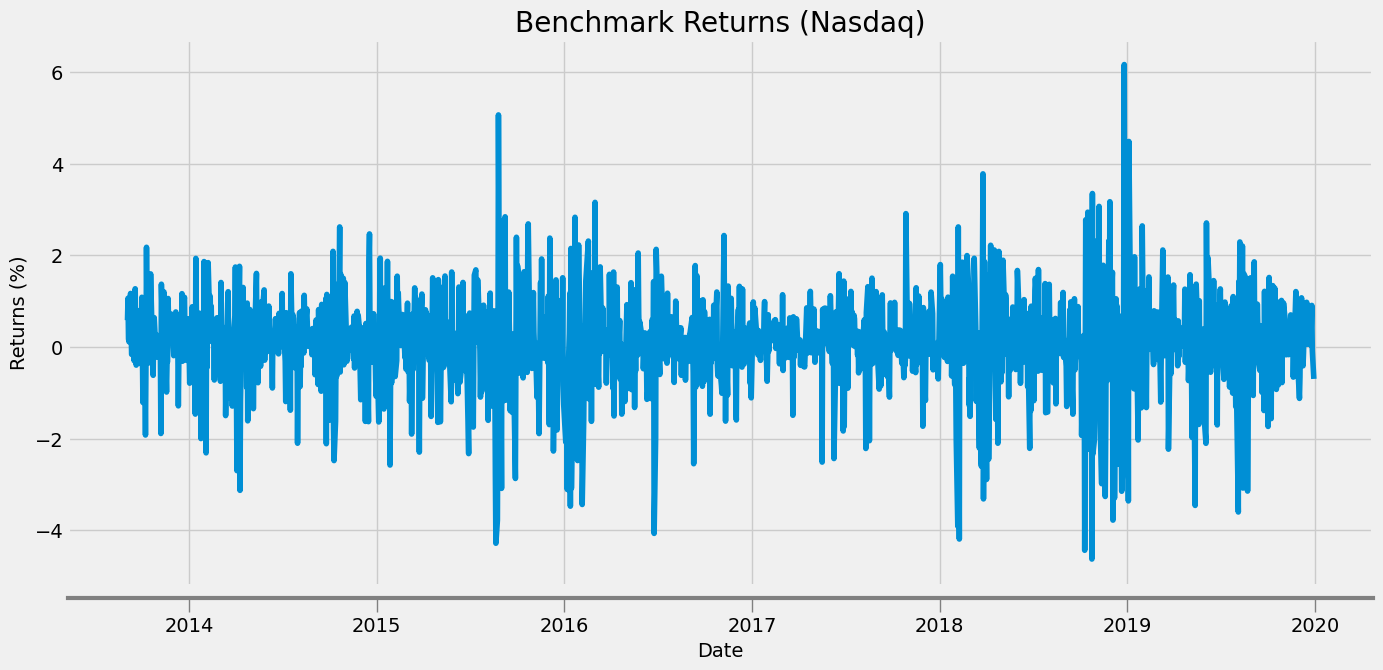

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
nasdaq_returns.plot(ax=ax)

# Shape the bottom part of the plot
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', direction='out', length=10, width=1, color='gray')

plt.title('Benchmark Returns (Nasdaq)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')

plt.savefig('../plots/benchmark_returns.png', dpi=300, bbox_inches='tight')
plt.show();

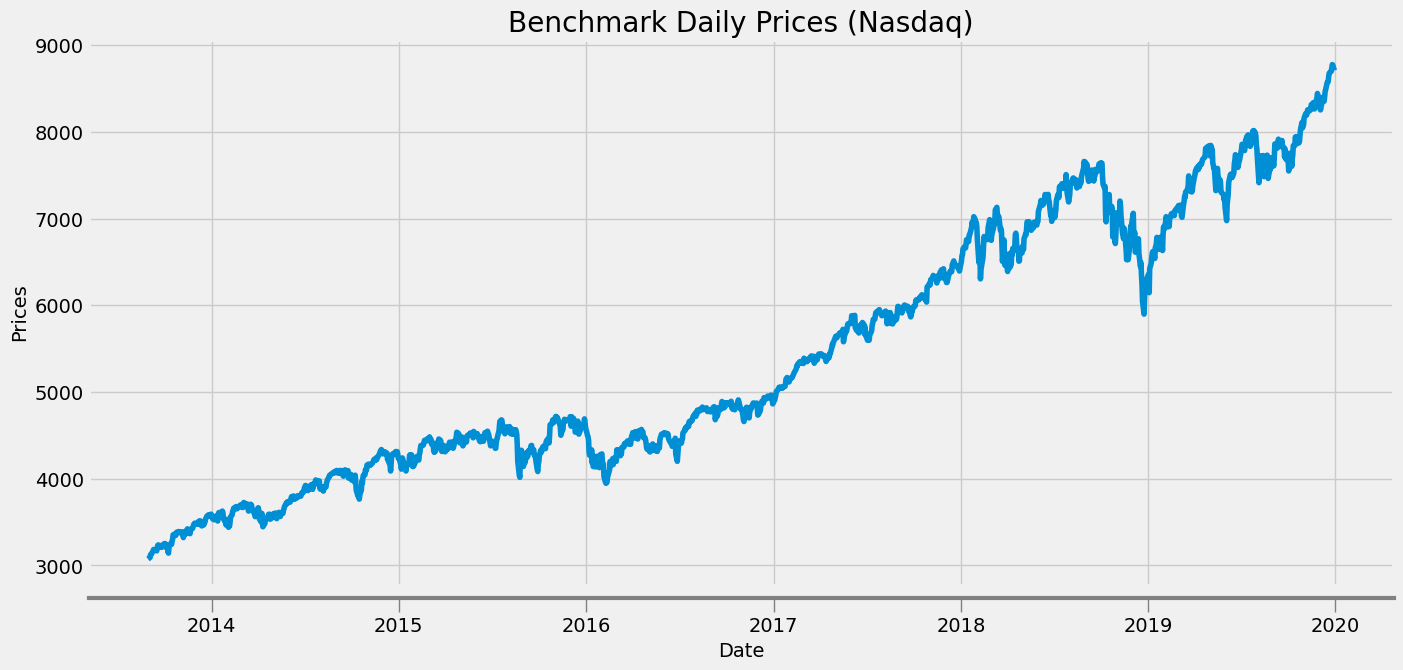

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
nasdaq.plot(ax=ax)

# Shape the bottom part of the plot
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', direction='out', length=10, width=1, color='gray')

plt.title('Benchmark Daily Prices (Nasdaq)')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.savefig('../plots/benchmark_prices.png', dpi=300, bbox_inches='tight')
plt.show();

In [34]:
# Write to disk
nasdaq.to_csv('../data/nasdaq_100.csv')

### EDA

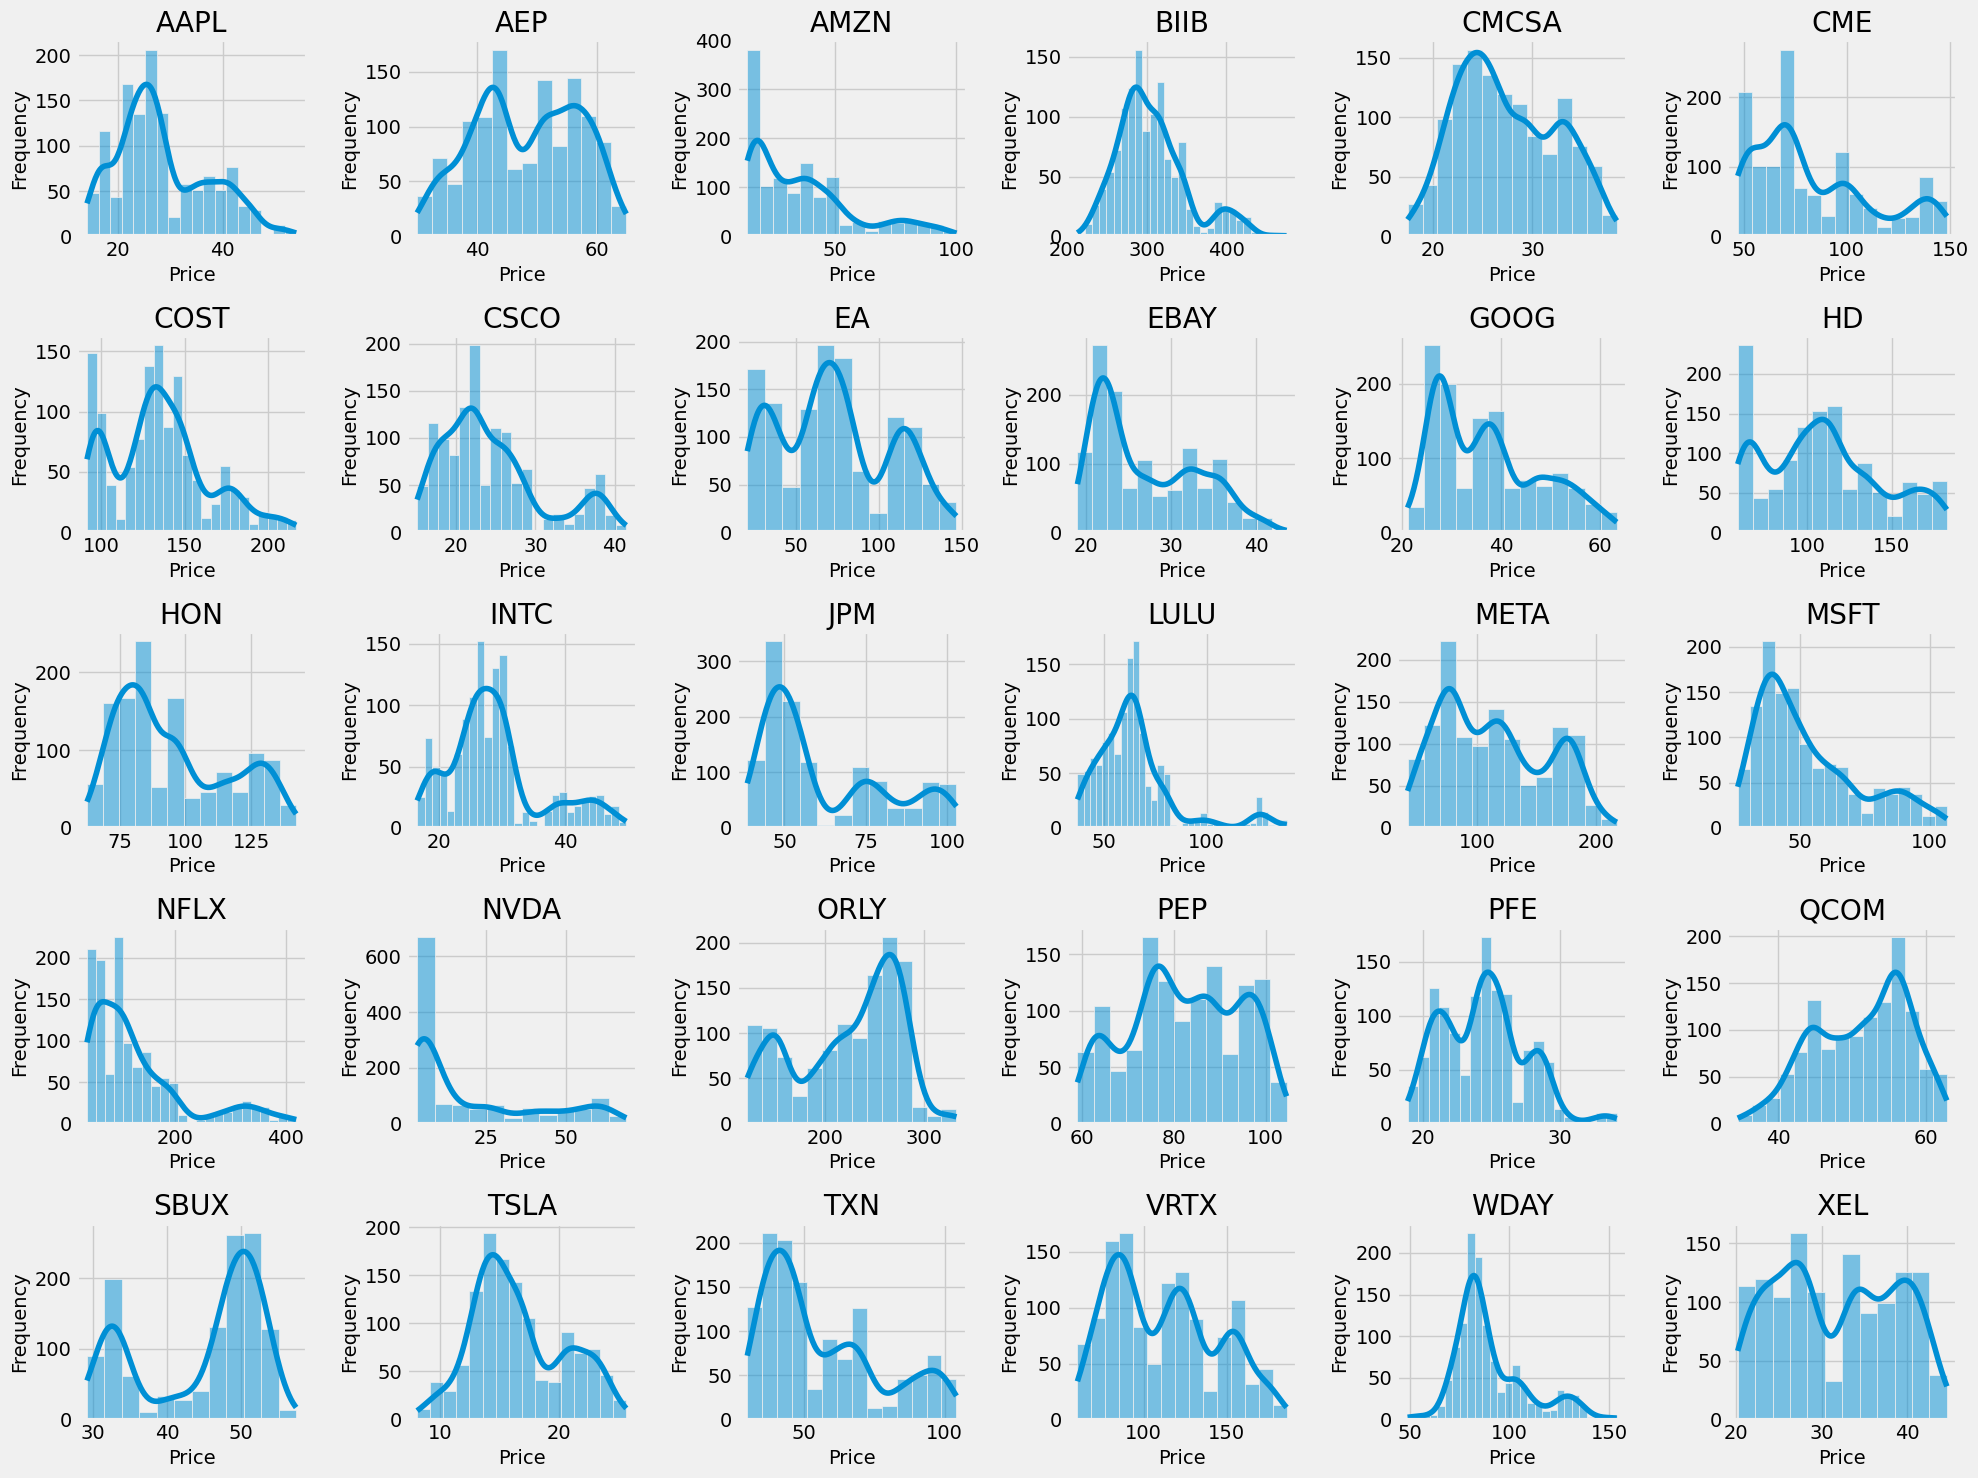

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))

# Flatten the axes array
axes = axes.flatten()

for i, col in enumerate(in_sample_data.columns):
    ax = axes[i]
    sns.histplot(in_sample_data[col], kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

fig.tight_layout()

# display the plot
plt.show();

Next, we will apply PCA to the 30 dimensional data matrix to further explore the intrinsic dimensionality of the matrix. We build a pipeline as follows:

In [36]:
pca_pipeline = Pipeline([('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)), ('pca', PCA(n_components=30))])

pca_pipeline.fit(in_sample_data)

Pipeline(steps=[('power_transformer', PowerTransformer()),
                ('pca', PCA(n_components=30))])

We can plot the scree plot to examine the effectiveness of PCA:

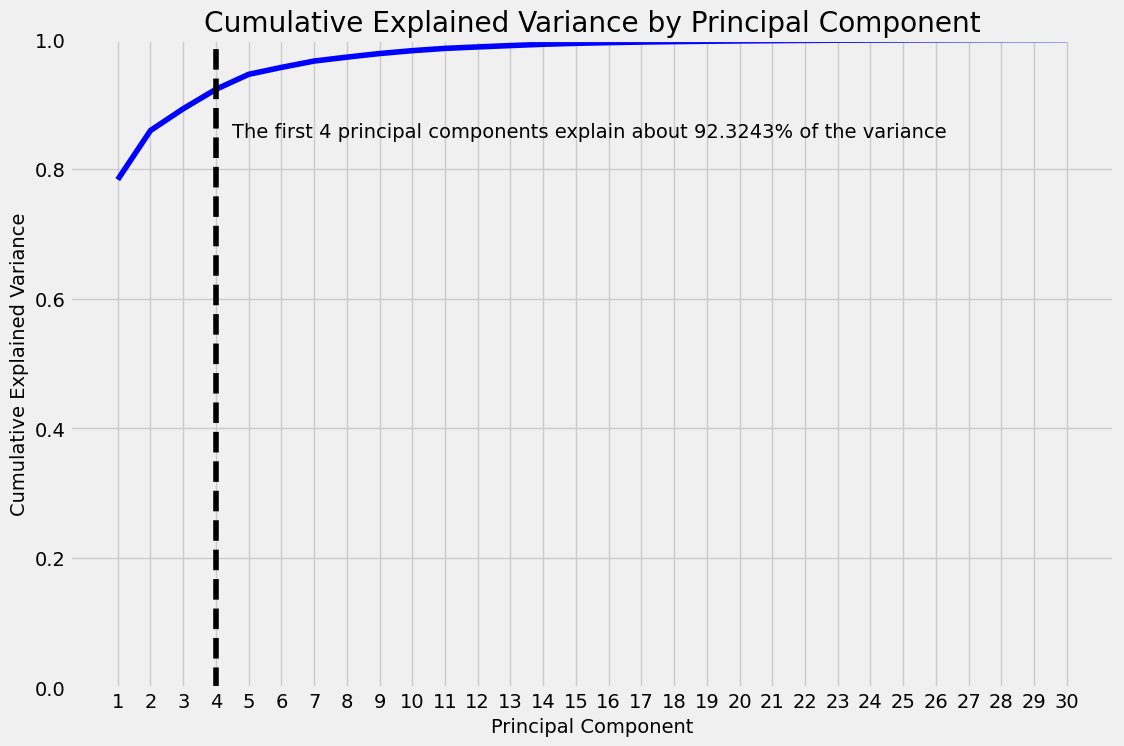

In [37]:
# Cumulative explained variance
cum_exp_var = np.cumsum(pca_pipeline['pca'].explained_variance_ratio_)
pc_indices = range(1, pca_pipeline['pca'].n_components + 1)
# Number of principal components that explain 90% of the variance
num_pc_90 = sum(cum_exp_var <= 0.90) + 1

plt.plot(pc_indices, cum_exp_var, color='blue')
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=num_pc_90, color='black', linestyle='--')
plt.text(num_pc_90 + 0.5, 0.85, f'The first {num_pc_90} principal components explain about {round(cum_exp_var[num_pc_90 - 1] * 100, 4)}% of the variance', color='black')
plt.title('Cumulative Explained Variance by Principal Component')
plt.show();

On the other hand:

In [38]:
# First two principal components
cum_exp_var[:2]

array([0.78391304, 0.85968296])

We can plot the first two principal components and examine the factor loadings. These are the eigenvectors of the optimization problem:

In [39]:
pcs = pd.DataFrame(pca_pipeline.transform(in_sample_data), columns=[f'PC{i}' for i in range(1, pca_pipeline['pca'].n_components + 1)])
pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.164248,2.165008,-0.175956,2.131206,-2.039180,-0.534699,-0.760707,-0.579008,-1.045281,0.141202,...,-0.079589,-0.091060,0.086659,0.105719,0.127614,0.060484,0.143130,-0.155217,0.003877,-0.029234
1,9.066801,1.854469,-0.256690,1.952859,-1.925566,-0.471518,-0.521964,-0.570328,-0.889780,0.156106,...,-0.053066,0.000605,0.139562,0.014628,0.081405,0.083229,-0.019024,-0.121743,0.008204,-0.017839
2,8.871965,1.540590,-0.411163,1.727115,-1.844006,-0.448128,-0.363537,-0.650078,-0.776356,0.205596,...,-0.062378,0.048871,0.244000,-0.014353,0.092639,0.133294,-0.108217,-0.138657,0.060117,-0.001326
3,8.849407,1.570904,-0.377714,1.855771,-1.869992,-0.367418,-0.407257,-0.671873,-0.802064,0.181929,...,-0.086211,0.070579,0.186539,-0.014821,0.083278,0.073929,-0.171358,-0.053090,0.039665,-0.001068
4,8.814829,1.546213,-0.311850,1.992811,-1.939633,-0.328868,-0.399008,-0.686218,-0.770415,0.042063,...,-0.021704,0.057056,0.194257,-0.001944,0.053274,-0.006183,-0.201249,-0.049051,0.002727,0.016650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,-8.710390,-2.062826,-2.264751,1.013424,0.428982,0.312151,-0.228513,1.002630,-0.778859,-0.303069,...,-0.199801,-0.059146,0.047659,0.005352,0.007222,0.059400,0.132637,-0.059969,-0.079375,-0.043488
1256,-8.738633,-2.093910,-2.237966,1.025877,0.435953,0.391568,-0.277764,0.923530,-0.722158,-0.284139,...,-0.169587,-0.098935,0.059990,0.000499,-0.017476,0.053828,0.099433,-0.049515,-0.078690,-0.024234
1257,-8.692281,-2.317638,-2.337478,1.163719,0.663407,0.501431,-0.296130,0.825223,-0.825335,-0.336753,...,-0.180802,-0.080095,0.063506,-0.000341,-0.050773,0.019642,0.141792,-0.049151,-0.095194,-0.041653
1258,-8.811196,-2.298846,-2.371177,1.076513,0.654657,0.456160,-0.285882,0.808734,-0.708997,-0.427569,...,-0.192451,-0.094876,0.083570,-0.028857,-0.045442,0.044172,0.158425,-0.068221,-0.086106,-0.042231


In [40]:
loadings = pd.DataFrame(pca_pipeline['pca'].components_.T[:, :2], columns=['PC ' + str(i) for i in range(1, 3)], index=in_sample_data.columns)
loadings

,PC 1,PC 2
AAPL,-0.193180,-0.156757
AEP,-0.195080,0.045173
AMZN,-0.197764,0.101103
BIIB,-0.002655,-0.506899
CMCSA,-0.190088,0.022160
CME,-0.203304,0.002046
COST,-0.199163,0.043538
CSCO,-0.199629,-0.054460
EA,-0.203097,0.023201
EBAY,-0.193611,-0.014404


These are the loadings--- how much each stock price series contributes to the first two principal components. To find out the top five stocks that contributed the most to each of the principal components:

In [41]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 1', ascending=False).iloc[:5, 0]

HD      0.203915
HON     0.203583
CME     0.203304
EA      0.203097
META    0.203067
Name: PC 1, dtype: float64

In [42]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 2', ascending=False).iloc[:5, 1]

BIIB    0.506899
QCOM    0.494273
WDAY    0.394928
SBUX    0.298210
VRTX    0.259237
Name: PC 2, dtype: float64

We plot the scatter plot of the first two principal components as follows:

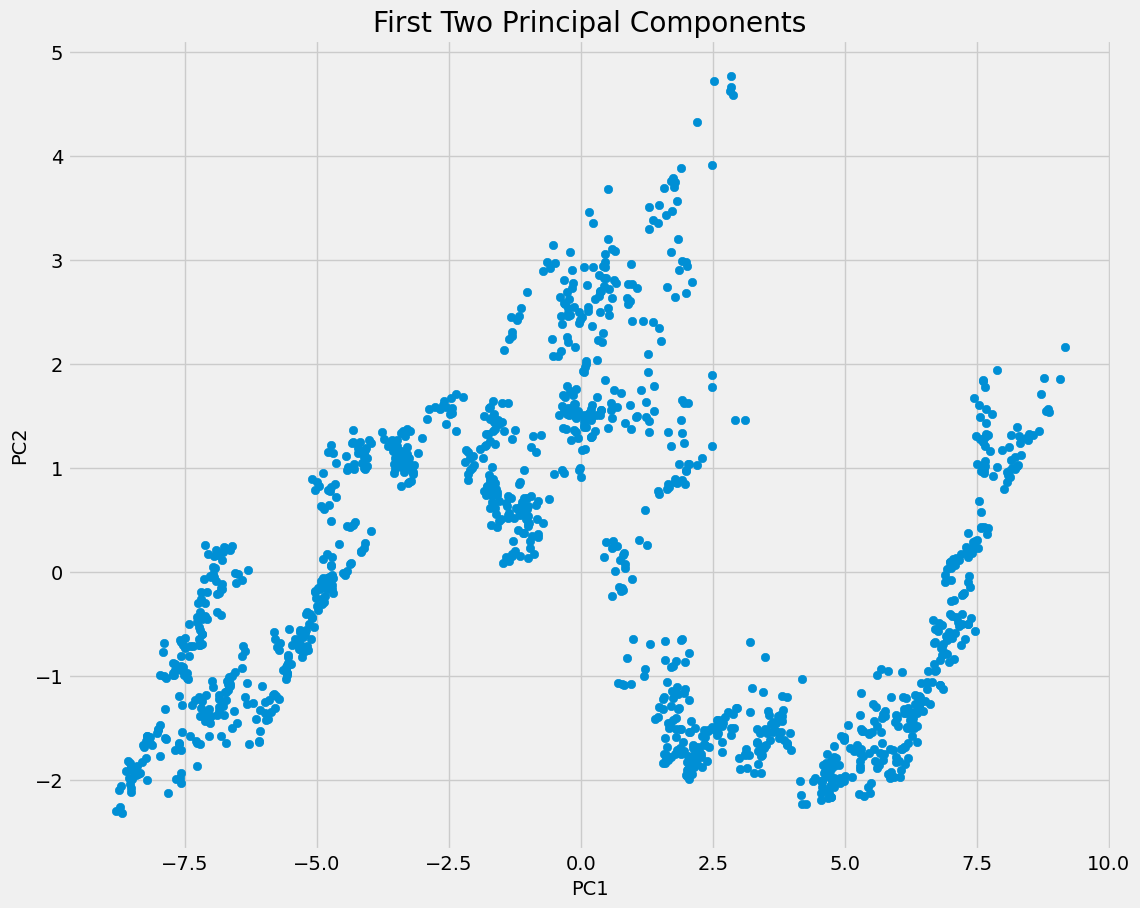

In [43]:
# Plot the first two principal components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(pcs['PC1'], pcs['PC2'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('First Two Principal Components')
plt.show();

Using TSNE:

In [44]:
tsne_mapping = TSNE(n_components=2, perplexity=100, learning_rate='auto', random_state=seed).fit_transform(pcs)

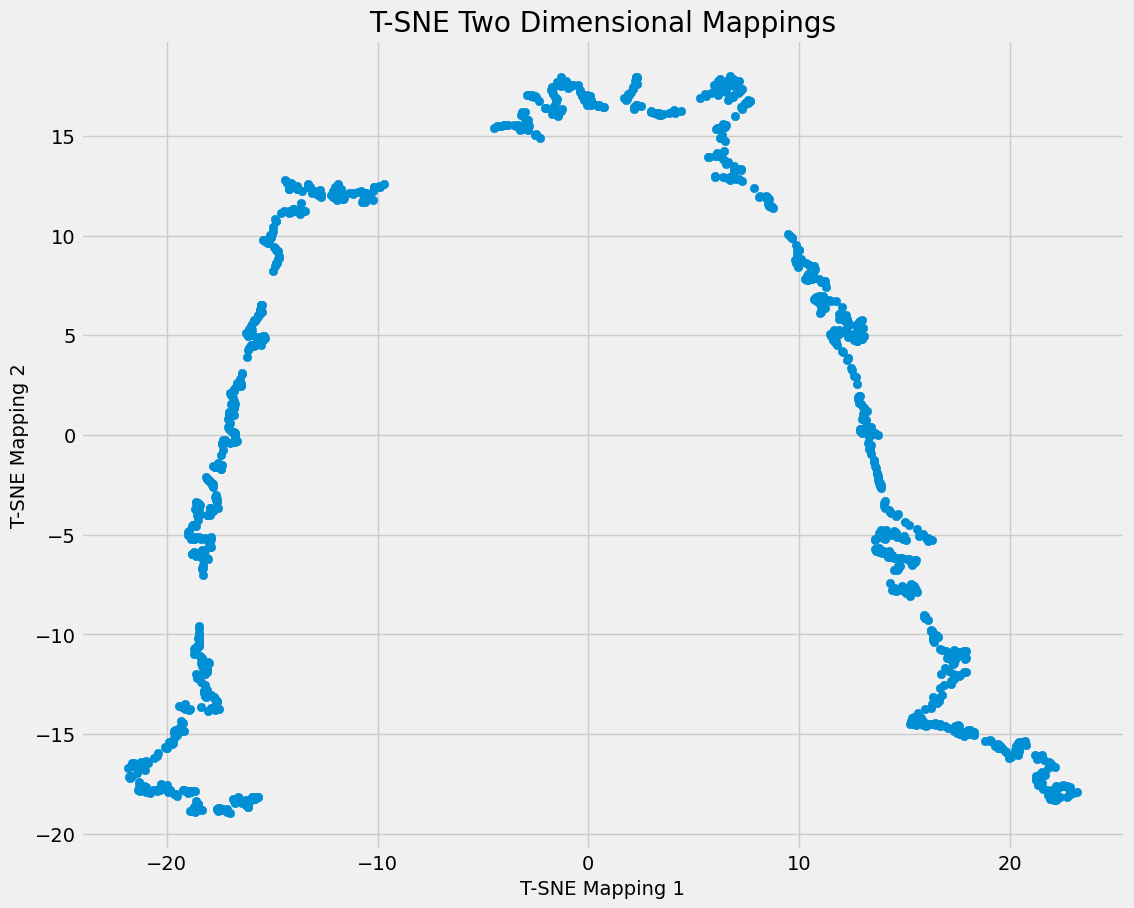

In [45]:
# Plot the first two t-SNE components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tsne_mapping[:, 0], tsne_mapping[:, 1])
ax.set_xlabel('T-SNE Mapping 1')
ax.set_ylabel('T-SNE Mapping 2')
ax.set_title('T-SNE Two Dimensional Mappings')
plt.show();

## Exponentially Weighted Moving Expected Returns

The mean-variance optimization requires knowledge of the expected returns. For our purposes, we will use the exponentially-weighted mean of (daily) historical returns. The exponentially weighted moving average (EWMA) is an approach such that older observations are given lower weights compared to more recent observations, and the weights decrease exponentially over time. In `PyPortfolioOpt`'s implementation, the hyperparameter to tune is the `span`, which is the time-span for the EMA. This gives us the ability to decide exactly how much more weight is given to recent data. Generally, it is advisable to use a higher span – in the limit, this tends towards the mean historical return.

The EMA captures the intuition that recent prices are (exponentially) more relevant than previous prices. If we let $p_0$ denote today's price, $p_1$ denote yesterday's price, $p_n$ denote the price $n$ days ago, the exponentially weighted mean is given by:

$$
\alpha\left[p_0+(1-\alpha) p_1+(1-\alpha)^2 p_2+\ldots+(1-\alpha)^n p_n+\ldots\right]
$$

where $\alpha$ parametrizes the decay rate $(0<|\alpha|<1)$: by observation we note that higher $\alpha$ gives more weight to recent results, and lower $\alpha$ causes the exponential mean to tend to the arithmetic mean. Additionally, because $\frac{1}{\alpha}=1+(1-\alpha)+(1-\alpha)^2+\ldots$, we note that the 'weights' sum to one.

In practice, we do not compute the infinite sum above. Rather, observing that the weights rapidly become negligible, we limit the calculation to some window. This window is not to be confused with the `span` of the EMA, which is another way of specifying the decay rate - a good explanation can be found on the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#exponentially-weighted-window).

The EMA is useful because it 'reacts' to recent data much better than the SMA owing to the exponential weighting scheme, while still preserving the memory of the time series.

In [46]:
in_sample_returns_exp = ema_historical_return(in_sample_data, returns_data=False, span=500, frequency=252)
in_sample_returns_exp

AAPL     0.500905
AEP      0.117780
AMZN     0.824227
BIIB     0.243122
CMCSA    0.095822
CME      0.338557
COST     0.343630
CSCO     0.357166
EA       0.137956
EBAY     0.033768
GOOG     0.317044
HD       0.264616
HON      0.207433
INTC     0.211945
JPM      0.265223
LULU     0.841670
META     0.194224
MSFT     0.481970
NFLX     0.928115
NVDA     1.022227
ORLY     0.370517
PEP      0.068248
PFE      0.238859
QCOM     0.237722
SBUX    -0.000644
TSLA     0.140194
TXN      0.317641
VRTX     0.449545
WDAY     0.505506
XEL      0.137205
Name: 2018-08-30 00:00:00, dtype: float64

In [47]:
# Write the in-sample returns to disk
in_sample_returns_exp.to_csv('../data/in_sample_returns_exp.csv')

## Capital Asset Pricing Model Estimated Return

The Capital Asset Pricing Model (CAPM) describes the relationship between systematic risk, or the general perils of investing, and expected return for assets, particularly stocks. It is a finance model that establishes a linear relationship between the required return on an investment and risk. The model is based on the relationship between an asset's beta, the risk-free rate (typically the Treasury bill rate), and the equity risk premium, or the expected return on the market minus the risk-free rate.

$$
E R_i=R_f+\beta_i\left(E R_m-R_f\right)
$$

where:

* $E R_i=$ expected return of investment
* $R_f=$ risk-free rate
* $\beta_i=$ beta of the investment
* $\left(E R_m-R_f\right)=$ market risk premium

The risk for rate we will use is the **Treasury Par Yield Curve Rates**. These rates are commonly referred to as "Constant Maturity Treasury" rates, or CMTs. Yields are interpolated by the Treasury from the daily par yield curve. This curve, which relates the yield on a security to its time to maturity, is based on the closing market bid prices on the most recently auctioned Treasury securities in the over-the-counter market. These par yields are derived from indicative, bid-side market price quotations (not actual transactions) obtained by the Federal Reserve Bank of New York at or near 3:30 PM each trading day. The CMT yield values are read from the par yield curve at fixed maturities, currently 1, 2, 3, 4 and 6 months and 1, 2, 3, 5, 7, 10, 20, and 30 years. This method provides a par yield for a 10-year maturity, for example, even if no outstanding security has exactly 10 years remaining to maturity.

We will use the 1 YR rate to match more or less to our investment horizon. As of today, that rate is $5.06\%$. In the optimization notebook, we will interpolate this value using cubic spline.

In [48]:
in_sample_returns_capm = capm_return(in_sample_data, returns_data=False, risk_free_rate= 0.0506, frequency=252)
in_sample_returns_capm

AAPL     0.242691
AEP      0.121734
AMZN     0.310693
BIIB     0.319457
CMCSA    0.210439
CME      0.200282
COST     0.176650
CSCO     0.244024
EA       0.280723
EBAY     0.250456
GOOG     0.283368
HD       0.213136
HON      0.223642
INTC     0.268520
JPM      0.245739
LULU     0.244106
META     0.324392
MSFT     0.277606
NFLX     0.380721
NVDA     0.354198
ORLY     0.219789
PEP      0.150381
PFE      0.186772
QCOM     0.253976
SBUX     0.222749
TSLA     0.367736
TXN      0.277014
VRTX     0.372825
WDAY     0.369202
XEL      0.116311
Name: mkt, dtype: float64

In [49]:
# Write the in-sample returns to disk
in_sample_returns_capm.to_csv('../data/in_sample_returns_capm.csv')

## Risk Model

In addition to the expected returns, mean-variance optimization requires a risk model, some way of quantifying asset risk. The most commonly-used risk model is the covariance matrix, which describes asset volatilities and their co-dependence. 

The easiest approach is to take two price series (e.g stock prices for AAPL and GOOG), then compute the daily percentage change or log returns, before feeding these into a covariance calculation. This does work and is the standard approach. But this may throw away a good deal of information, because covariance does not preserve the order of observations.

In other words, we will get the same covariance whether we provide $\left(x_2, y_2\right),\left(x_{17}, y_{17}\right),\left(x_8, y_8\right), \ldots$ or $\left(x_1, y_1\right),\left(x_2, y_2\right),\left(x_3, y_3\right), \ldots$.

In the case of time series, the order of the returns is of fundamental importance. Therefore, we need some way of incorporating the sequential nature of the data into the definition of covariance. 

### Exponentially Weighted Covariance Estimator

Fortunately, it is simple to apply our intuition of the EMA to come up with a similar metric for covariance. We will rewrite the definition of covariance portfolio as follows:

$$
\operatorname{Cov}(x, y)=\frac{1}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Rather than letting $\left(x_i, y_i\right)$ be any observations from the dataset, we will preserve the order by saying that $\left(x_i, y_i\right)$ denotes the returns of asset $X$ and $Y$ $i$ days ago. Thus $\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)$ specifically refers to the co-variation of the returns yesterday. We simply give each co-variation term an exponential weight as follows:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+(1-\alpha)\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+(1-\alpha)^N\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Or more simply:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N} \sum_{i=1}^N(1-\alpha)^{i-1}\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)
$$

This simple procedure is all that is required to incorporate the temporal nature of asset returns into the covariance matrix.

In [50]:
in_sample_cov_exp = exp_cov(in_sample_data, returns_data=False, span=500, frequency=252)

Note that, for optimization reasons, the estimator for the covariance matrix should be positive semidefinite--- a matrix whose eigenvalues are nonnegative. There is a lot of equivalent ways to characterize positive semidefiniteness. For our purposes, it is important since the volatility measure should be non-negative. Below, we check if a covariance matrix is positive semidefinite, and if not, fix it with the 'spectral' method. It sets negative eigenvalues to zero and rebuilds the matrix.

In [51]:
in_sample_cov_exp = fix_nonpositive_semidefinite(in_sample_cov_exp)
in_sample_cov_exp.style.background_gradient(cmap='coolwarm')

,AAPL,AEP,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,GOOG,HD,HON,INTC,JPM,LULU,META,MSFT,NFLX,NVDA,ORLY,PEP,PFE,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
AAPL,0.045311,0.000424,0.024034,0.019502,0.011343,0.012690,0.010685,0.019874,0.021643,0.015792,0.024072,0.011288,0.011667,0.025470,0.014674,0.010798,0.023354,0.024295,0.026912,0.032584,0.010363,0.006426,0.007862,0.023631,0.011818,0.027512,0.024436,0.022126,0.026249,0.000910
AEP,0.000424,0.022978,0.001001,0.000385,0.004399,-0.002222,0.004820,0.002837,0.003297,-0.001770,0.001192,0.003066,0.002287,0.001212,-0.004777,-0.000646,-0.000700,0.003682,0.001188,0.000690,0.003217,0.009415,0.003435,0.004117,0.003812,-0.001025,0.001670,0.002506,0.001195,0.021029
AMZN,0.024034,0.001001,0.063239,0.021328,0.007638,0.012625,0.009856,0.022490,0.028094,0.015754,0.034234,0.013243,0.013273,0.028663,0.015206,0.010086,0.040208,0.033844,0.047599,0.040878,0.012193,0.005064,0.007542,0.019737,0.013989,0.038340,0.023370,0.027374,0.034873,0.001812
BIIB,0.019502,0.000385,0.021328,0.117025,0.010753,0.014379,0.010111,0.016095,0.022893,0.018333,0.022552,0.014597,0.014597,0.025694,0.017630,0.017862,0.042121,0.023241,0.029199,0.025629,0.011078,0.007299,0.018284,0.017292,0.010027,0.020591,0.024196,0.040915,0.021123,0.001163
CMCSA,0.011343,0.004399,0.007638,0.010753,0.057100,0.010877,0.012208,0.015712,0.012625,0.009777,0.014189,0.011887,0.009758,0.016401,0.015311,0.008762,0.003591,0.013645,0.016875,0.014942,0.014021,0.008127,0.009200,0.017271,0.011632,0.012749,0.015148,0.022588,0.011172,0.004277
CME,0.012690,-0.002222,0.012625,0.014379,0.010877,0.033166,0.010553,0.015250,0.015311,0.015671,0.015351,0.012556,0.013474,0.016552,0.021912,0.012182,0.015418,0.015976,0.017515,0.018239,0.011998,0.005198,0.010653,0.011558,0.008860,0.015102,0.014100,0.014540,0.014693,-0.002372
COST,0.010685,0.004820,0.009856,0.010111,0.012208,0.010553,0.031256,0.013335,0.009744,0.008464,0.012159,0.013574,0.009776,0.014770,0.011631,0.010482,0.007865,0.013513,0.013325,0.015595,0.016354,0.007694,0.009138,0.012452,0.009238,0.013885,0.013462,0.012092,0.007829,0.004782
CSCO,0.019874,0.002837,0.022490,0.016095,0.015712,0.015250,0.013335,0.042204,0.021789,0.017312,0.024048,0.015569,0.016923,0.029644,0.019867,0.015882,0.018016,0.025398,0.034212,0.032415,0.016596,0.007331,0.012989,0.023502,0.011970,0.025978,0.024786,0.022576,0.027810,0.003180
EA,0.021643,0.003297,0.028094,0.022893,0.012625,0.015311,0.009744,0.021789,0.084540,0.023120,0.030263,0.013682,0.014958,0.030234,0.014103,0.018802,0.033018,0.031329,0.038082,0.050896,0.009000,0.010059,0.008339,0.022994,0.009881,0.039966,0.029933,0.023274,0.035002,0.003558
EBAY,0.015792,-0.001770,0.015754,0.018333,0.009777,0.015671,0.008464,0.017312,0.023120,0.068776,0.022819,0.009572,0.014527,0.020105,0.016932,0.011844,0.015778,0.021412,0.027491,0.029772,0.002543,0.002860,0.010531,0.017766,0.006476,0.019892,0.023906,0.023964,0.022761,-0.002314


In [52]:
# Write the in-sample covariance matrix to disk
in_sample_cov_exp.to_csv('../data/in_sample_cov_exp.csv')

### Shrinkage Estimators

We start with the sample covariance matrix $S$:

- The sample covariance is easy to compute and is an unbiased estimator, but there tends to be a lot of estimation error, particularly when there are fewer prices (rows of observations) than there are stocks (i.e $N \geq T)$.
  
- On the other hand, there exist highly structured estimators such as Sharpe's one factor model (Sharpe 1963), which may be highly biased but have little estimation error.
  
- The principle behind shrinkage is to compromise between some highly structured estimator $F$ (also known as the shrinkage target) and another unstructured estimator.
  
- In the case of covariance, the unstructured estimator is the sample covariance matrix $S$.
  
- The compromise between these two estimators is determined by the shrinkage coefficient $\delta$. The final estimator is obtained by computing a convex linear combination (a linear combination of points (which can be vectors, scalars, or more generally points in an affine space) where all coefficients are non-negative and sum to 1):
  
$$
\delta F+(1-\delta) S, \quad 0 \leq \delta \leq 1
$$

- This technique is called shrinkage, since the sample covariance matrix is 'shrunk' towards the structured estimator. The number $\delta$ is referred to as the shrinkage constant. Intuitively, it measures the weight that is given to the structured estimator. Shrinkage estimators have a long and successful history in statistics. The beauty of the principle is that by properly combining two 'extreme' estimators one can obtain a 'compromise' estimator that performs better than either extreme. 

- Any shrinkage estimator has three ingredients: 
  - An estimator with no structure
  - An estimator with a lot of structure
  - A shrinkage constant

- The shrinkage target $F$ should involve only a small number of free parameters (highly structured), but also provides some insight as to the character of the quantity being estimated. In `PyPortfolioOpt`, the following options are available:
  
  - the `constant_variance` shrinkage, i.e the target is the diagonal matrix with the mean of asset variances on the diagonals and zeroes elsewhere. This is the shrinkage offered by `sklearn.LedoitWolf`
  - the `single_factor` shrinkage, which is based on Sharpe's single-index model which effectively uses a stock's beta to the market as a risk model. See [Ledoit and Wolf 2001](http://www.ledoit.net/ole2.pdf).
  - the `constant_correlation` shrinkage, in which all pairwise correlations are set to the average correlation (sample variances are unchanged). See [Ledoit and Wolf 2003](http://www.ledoit.net/honey.pdf)

In [53]:
in_sample_cov_shrinkage = CovarianceShrinkage(
    prices=in_sample_data,
    returns_data=False,
    frequency=252,
    log_returns=False
).ledoit_wolf('constant_variance')

Note that the shrinkage constant is automatically estimated. In the paper listed above, the formula for this optimal intensity is derived.

In [54]:
in_sample_cov_shrinkage = fix_nonpositive_semidefinite(in_sample_cov_shrinkage)
in_sample_cov_shrinkage.style.background_gradient(cmap='coolwarm')

,AAPL,AEP,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,GOOG,HD,HON,INTC,JPM,LULU,META,MSFT,NFLX,NVDA,ORLY,PEP,PFE,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
AAPL,0.052155,0.004725,0.022036,0.016405,0.012482,0.012327,0.010598,0.017495,0.019641,0.017094,0.020120,0.013140,0.014648,0.019698,0.016320,0.010315,0.023739,0.021496,0.024226,0.026287,0.012306,0.008311,0.009490,0.019738,0.014438,0.025403,0.022281,0.022603,0.026270,0.003869
AEP,0.004725,0.027819,0.005059,0.005831,0.006399,0.001714,0.006952,0.005373,0.008177,0.002472,0.005631,0.006243,0.007129,0.006477,0.001516,0.003882,0.004395,0.008041,0.004240,0.005276,0.006073,0.009954,0.005648,0.006086,0.006450,0.002993,0.005778,0.005369,0.002776,0.022327
AMZN,0.022036,0.005059,0.084599,0.023357,0.013669,0.012867,0.012734,0.018930,0.028986,0.019542,0.037248,0.016142,0.015430,0.020942,0.018258,0.015562,0.042563,0.029338,0.045544,0.030380,0.016686,0.009315,0.011259,0.016479,0.022846,0.040278,0.021764,0.032331,0.040085,0.005931
BIIB,0.016405,0.005831,0.023357,0.122930,0.018562,0.017347,0.011470,0.016539,0.021761,0.022600,0.025200,0.017086,0.020611,0.019596,0.024096,0.021684,0.033649,0.019500,0.032437,0.024681,0.014554,0.009775,0.023229,0.022419,0.016773,0.028988,0.023796,0.061881,0.033041,0.004905
CMCSA,0.012482,0.006399,0.013669,0.018562,0.041963,0.013277,0.011756,0.015148,0.012395,0.013136,0.013660,0.013123,0.014248,0.014763,0.017775,0.012303,0.013713,0.015306,0.016283,0.017181,0.013882,0.009174,0.011896,0.015362,0.013039,0.017540,0.014825,0.023789,0.017098,0.005555
CME,0.012327,0.001714,0.012867,0.017347,0.013277,0.037684,0.010510,0.013065,0.016486,0.015243,0.014329,0.012660,0.014587,0.013666,0.022439,0.011014,0.016444,0.014530,0.016695,0.014171,0.014366,0.006947,0.012252,0.011988,0.011815,0.014208,0.014052,0.016649,0.015686,0.001834
COST,0.010598,0.006952,0.012734,0.011470,0.011756,0.010510,0.030162,0.011435,0.010713,0.009606,0.012075,0.013108,0.010674,0.011742,0.012028,0.013190,0.010347,0.012922,0.012717,0.013209,0.014071,0.009374,0.008778,0.010391,0.011940,0.010731,0.012231,0.012459,0.010303,0.006420
CSCO,0.017495,0.005373,0.018930,0.016539,0.015148,0.013065,0.011435,0.043175,0.019105,0.017614,0.018392,0.014124,0.016754,0.024233,0.019687,0.015117,0.017394,0.022418,0.023626,0.027663,0.015773,0.009400,0.012199,0.020496,0.014111,0.020595,0.022731,0.020167,0.025778,0.004854
EA,0.019641,0.008177,0.028986,0.021761,0.012395,0.016486,0.010713,0.019105,0.094795,0.018973,0.022914,0.014009,0.016671,0.022358,0.015897,0.012225,0.028520,0.022864,0.029542,0.035597,0.013529,0.011077,0.010818,0.018892,0.015001,0.027460,0.024413,0.020714,0.025882,0.006784
EBAY,0.017094,0.002472,0.019542,0.022600,0.013136,0.015243,0.009606,0.017614,0.018973,0.065916,0.021461,0.012585,0.015078,0.017591,0.018438,0.012560,0.018928,0.020702,0.027667,0.027905,0.009831,0.007180,0.012107,0.021274,0.012228,0.025193,0.022750,0.025110,0.028412,0.002213


In [55]:
# Write the in-sample covariance matrix to disk
in_sample_cov_shrinkage.to_csv('../data/in_sample_cov_shrinkage.csv')